In [6]:
import heapq
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys


In [5]:

# Assuming input_frame is preloaded with IPM and pre-processed as per the paper's description

class Pixel:
    def __init__(self, x, y, i, label, neighbours):
        self.x = x
        self.y = y
        self.i = i
        self.label = label
        self.neighbours = neighbours
    
    def __lt__(self, nxt):
        return self.i < nxt.i

class InitialDistanceMap:
    def __init__(self, seed_id, distance_to_seed):
        self.id = seed_id
        self.distance = distance_to_seed
        
    def __lt__(self, iter_var):
        return self.distance < iter_var.distance

def initialize_image_matrix(frame, x_seed_count, y_seed_count):
    # Static Phase: Seed Initialization
    seeds = []
    points_dict = {}
    label_matrix = np.zeros_like(frame)
    
    x_coords = np.linspace(0, frame.shape[0]-1, x_seed_count).astype('int')
    y_coords = np.linspace(0, frame.shape[1]-1, y_seed_count).astype('int')

    for x in x_coords:
        for y in y_coords:
            seeds.append((x, y))
    
    for x in tqdm(range(frame.shape[0])):
        for y in range(frame.shape[1]):
            points_dict[(x, y)] = Pixel(x, y, -1, -1, -1)
            _temporary_heap = []
            heapq.heapify(_temporary_heap)
            for seed_id, seed in enumerate(seeds):
                point_1 = seed
                point_2 = np.array((x, y))
                dist = np.linalg.norm(point_1 - point_2)
                heapq.heappush(_temporary_heap, InitialDistanceMap(seed_id, dist))
            
            initial_label = heapq.heappop(_temporary_heap).id
            points_dict[(x, y)] = Pixel(x, y, -1, initial_label, -1)
            label_matrix[x][y] = initial_label
            
    seeds_matrix = np.array(seeds).reshape(x_seed_count, y_seed_count)
    
    neighbour_hood_dict = {}
    for x in range(x_seed_count):
        for y in range(y_seed_count):
            neighbours = []
            for nx in range(max(0, x-1), min(x_seed_count, x+2)):
                for ny in range(max(0, y-1), min(y_seed_count, y+2)):
                    if nx == x and ny == y:
                        continue
                    neighbours.append((nx * y_seed_count) + ny)
            neighbour_hood_dict[x * y_seed_count + y] = neighbours
    # Calculate neighbours for seeds

    for point in list(points_dict.keys()):
        temp = points_dict[point]
        temp.neighbours = neighbour_hood_dict[temp.label]
        points_dict[point] = temp
        
    return label_matrix, seeds_matrix, seeds, neighbour_hood_dict, points_dict

# Dynamic Phase: Super-Pixel Refinement and Allocation
# This would be within the Algorithm_X2 class
# Omitted for brevity; it's assumed to be similar to the provided approach, with clear separation of static and dynamic phases
# Example logic for processing a pixel in the dynamic phase
def process_pixel(self, x, y):
    pixel = self.point_dict[(x, y)]
    pixel_intensity = self.frame[x, y]
    best_distance = sys.maxsize
    best_seed = None
    
    for neighbour_seed_id in pixel.neighbours:
        seed_x, seed_y = self.seeds[neighbour_seed_id]
        seed_intensity = self.centroids[neighbour_seed_id][2]
        distance = self.calculate_distance(x, y, pixel_intensity, seed_x, seed_y, seed_intensity)
        
        if distance < best_distance:
            best_distance = distance
            best_seed = neighbour_seed_id
    
    # Update pixel assignment
    if best_seed is not None:
        pixel.label = best_seed
        self.point_dict[(x, y)] = pixel
        # Update centroid calculation for the seed
        self.update_centroid(best_seed, x, y, pixel_intensity)

def update_centroid(self, seed_id, x, y, intensity):
    old_centroid = self.centroids[seed_id]
    new_x = (old_centroid[0] + x) / 2
    new_y = (old_centroid[1] + y) / 2
    new_intensity = (old_centroid[2] + intensity) / 2
    self.centroids[seed_id] = np.array([new_x, new_y, new_intensity])


# Incorporating Hough Transforms for Validation
def apply_hough_transforms(image):
    edges = cv2.Canny(image, 50, 150, apertureSize=3)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    lines_p = cv2.HoughLinesP(edges, 1, np.pi / 180, 50, minLineLength=50, maxLineGap=10)

    # Display the results
    for line in lines:
        for rho, theta in line:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 2)

    for line in lines_p:
        x1, y1, x2, y2 = line[0]
        cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 3)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()


In [ ]:
could you give full code, just to understand placement of everything, you don't need to define the functions, just put their names and give a pseudo code of sorts
# Assuming `input_frame` is your pre-processed IPM image
# label_matrix, seeds_matrix, seeds, neighbour_hood_dict, point_dict = initialize_image_matrix(input_frame, 9, 9)
# algorithm_op = Algorithm_X2(input_frame, seeds, point_dict)
# segmented_image = algorithm_op.return_image()

# Original Image Hough Transforms
# apply_hough_transforms(input_frame.copy())

# Segmented Image Hough Transforms
# apply_hough_transforms(segmented_image.copy())


In [ ]:
def apply_ht_on_segments(input_frame, segments):
    for segment in segments:
        # Assuming segment is a mask of the same size as input_frame, with True/1 for pixels within the segment
        # Extract segment region
        segment_region = np.zeros_like(input_frame)
        segment_region[segment] = input_frame[segment]
        
        # Apply Canny edge detection specifically on this segment
        edges = cv2.Canny(segment_region, 50, 150, apertureSize=3)
        
        # Apply HT or PHT specifically on the edges detected within this segment
        lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=50, maxLineGap=10)
        
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                cv2.line(segment_region, (x1, y1), (x2, y2), (255, 0, 0), 3)
        
        # Display or process the segment_region as needed
        plt.imshow(segment_region, cmap='gray')
        plt.title("HT or PHT on Segment")
        plt.show()


In [ ]:
def generate_segment_list(self):
    # Initialize a dictionary to hold pixel coordinates for each segment
    segments = {}
    for (x, y), pixel in self.point_dict.items():
        label = pixel.label
        if label not in segments:
            segments[label] = []
        segments[label].append((x, y))
    
    # Convert the dictionary to a list of numpy arrays for easy manipulation
    segment_arrays = []
    for label, pixels in segments.items():
        segment_array = np.zeros(self.frame.shape, dtype=bool)
        x_coords, y_coords = zip(*pixels)
        segment_array[x_coords, y_coords] = True
        segment_arrays.append(segment_array)
    
    return segment_arrays
# After segmentation
segment_arrays = algorithm_op.generate_segment_list()
    def generate_segment_list(self):
        # Initialize a dictionary to hold pixel coordinates for each segment
        segments = {}
        for (x, y), pixel in self.point_dict.items():
            label = pixel.label
            if label not in segments:
                segments[label] = []
            segments[label].append((x, y))
        
        # Convert the dictionary to a list of numpy arrays for easy manipulation
        segment_arrays = []
        for label, pixels in segments.items():
            segment_array = np.zeros(self.frame.shape, dtype=bool)
            x_coords, y_coords = zip(*pixels)
            segment_array[x_coords, y_coords] = True
            segment_arrays.append(segment_array)

In [7]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define or place your function definitions here
# - initialize_image_matrix(input_frame, x_seed_count, y_seed_count)
def initialize_image_matrix(frame, x_seed_count, y_seed_count):
    # Static Phase: Seed Initialization
    seeds = []
    points_dict = {}
    label_matrix = np.zeros_like(frame)
    
    x_coords = np.linspace(0, frame.shape[0]-1, x_seed_count).astype('int')
    y_coords = np.linspace(0, frame.shape[1]-1, y_seed_count).astype('int')

    for x in x_coords:
        for y in y_coords:
            seeds.append((x, y))
    
    for x in tqdm(range(frame.shape[0])):
        for y in range(frame.shape[1]):
            points_dict[(x, y)] = Pixel(x, y, -1, -1, -1)
            _temporary_heap = []
            heapq.heapify(_temporary_heap)
            for seed_id, seed in enumerate(seeds):
                point_1 = seed
                point_2 = np.array((x, y))
                dist = np.linalg.norm(point_1 - point_2)
                heapq.heappush(_temporary_heap, InitialDistanceMap(seed_id, dist))
            
            initial_label = heapq.heappop(_temporary_heap).id
            points_dict[(x, y)] = Pixel(x, y, -1, initial_label, -1)
            label_matrix[x][y] = initial_label
            
    seeds_matrix = np.array(seeds).reshape(x_seed_count, y_seed_count)
    # Generate seeds directly as a list of tuples for x and y coordinates
    seeds = [(x, y) for x in np.linspace(0, input_frame.shape[0]-1, 9).astype(int)
                    for y in np.linspace(0, input_frame.shape[1]-1, 9).astype(int)]

    neighbour_hood_dict = {}
    for x in range(x_seed_count):
        for y in range(y_seed_count):
            neighbours = []
            for nx in range(max(0, x-1), min(x_seed_count, x+2)):
                for ny in range(max(0, y-1), min(y_seed_count, y+2)):
                    if nx == x and ny == y:
                        continue
                    neighbours.append((nx * y_seed_count) + ny)
            neighbour_hood_dict[x * y_seed_count + y] = neighbours
    # Calculate neighbours for seeds

    for point in list(points_dict.keys()):
        temp = points_dict[point]
        temp.neighbours = neighbour_hood_dict[temp.label]
        points_dict[point] = temp
        
    return label_matrix, seeds_matrix, seeds, neighbour_hood_dict, points_dict
# - apply_hough_transforms(image)
def apply_hough_transforms(image):
    edges = cv2.Canny(image, 50, 150, apertureSize=3)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    lines_p = cv2.HoughLinesP(edges, 1, np.pi / 180, 50, minLineLength=50, maxLineGap=10)

    # Display the results
    for line in lines:
        for rho, theta in line:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 2)

    for line in lines_p:
        x1, y1, x2, y2 = line[0]
        cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 3)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
# - Algorithm_X2 class with methods:
#   - __init__(self, ipm_image_frame, seeds, point_dict)
#   - generate_super_pixels(self)
#   - generate_segment_list(self)
#   - return_image(self)
class Algorithm_X2:
    def __init__(self, ipm_image_frame, seeds, point_dict):
        self.frame = ipm_image_frame
        self.seeds = seeds
        self.point_dict = point_dict
        # Initialize an image to store the segmentation results
        self.segmented_image = np.zeros_like(self.frame)
    
    def generate_super_pixels(self):
        # This method should implement the logic for segmenting the image into super-pixels
        # Here's a simplified structure for demonstration
        for (x, y), pixel in self.point_dict.items():
            label = pixel.label
            # Assign the pixel value based on its label, for simplicity, we just copy the original value
            # In practice, you might want to apply specific logic based on the segment's properties
            self.segmented_image[x, y] = self.frame[x, y]
    
    def generate_segment_list(self):
        # Generates a list of boolean masks, each representing a segment
        segments = {}
        for (x, y), pixel in self.point_dict.items():
            label = pixel.label
            if label not in segments:
                segments[label] = np.zeros_like(self.frame, dtype=bool)
            segments[label][x, y] = True
        
        # Convert the segments dictionary to a list for easier processing later
        segment_list = list(segments.values())
        return segment_list

    def return_image(self):
        # Returns the segmented image
        return self.segmented_image
# - apply_ht_on_segments(input_frame, segment_arrays)
def apply_ht_on_segments(input_frame, segment_arrays):
    for segment_mask in segment_arrays:
        # Extract segment region using the mask
        segment_region = np.where(segment_mask, input_frame, 0)
        
        # Apply Canny edge detection and HT or PHT as shown in previous examples
        edges = cv2.Canny(segment_region.astype(np.uint8), 50, 150, apertureSize=3)
        lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=50, maxLineGap=10)
        
        # Display or process the results for each segment
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                cv2.line(segment_region, (x1, y1), (x2, y2), (255, 0, 0), 3)
        
        plt.imshow(segment_region, cmap='gray')
        plt.title("HT or PHT on Segment")
        plt.show()

def apply_ht_on_segments_and_combine(input_frame, segment_arrays):
    # Placeholder for aggregated line detections
    all_lines = []

    # Process each segment and collect lines
    for segment_mask in segment_arrays:
        segment_region = np.where(segment_mask, input_frame, 0)
        edges = cv2.Canny(segment_region.astype(np.uint8), 50, 150, apertureSize=3)
        lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=50, maxLineGap=10)

        if lines is not None:
            all_lines.extend(lines)
    
    # Create a new image or use the original to draw lines
    result_image = np.copy(input_frame)  # Or np.zeros_like(input_frame) for a blank canvas
    
    # Draw all lines on the result_image
    for line in all_lines:
        for x1, y1, x2, y2 in line:
            cv2.line(result_image, (x1, y1), (x2, y2), (255, 0, 0), 3)
    
    return result_image




In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import heapq

class Pixel:
    def __init__(self, x, y, intensity=-1, label=-1, neighbours=None):
        if neighbours is None:
            neighbours = []
        self.x = x
        self.y = y
        self.intensity = intensity
        self.label = label
        self.neighbours = neighbours

class InitialDistanceMap:
    def __init__(self, seed_id, distance_to_seed):
        self.id = seed_id
        self.distance = distance_to_seed
        
    def __lt__(self, other):
        return self.distance < other.distance

def initialize_image_matrix(frame, x_seed_count, y_seed_count):
    seeds = [(x, y) for x in np.linspace(0, frame.shape[0]-1, x_seed_count).astype(int)
                    for y in np.linspace(0, frame.shape[1]-1, y_seed_count).astype(int)]
    points_dict = {}
    label_matrix = np.zeros_like(frame, dtype=int)
    
    for x in range(frame.shape[0]):
        for y in range(frame.shape[1]):
            closest_seed = min(seeds, key=lambda seed: np.hypot(x-seed[0], y-seed[1]))
            label = seeds.index(closest_seed)
            points_dict[(x, y)] = Pixel(x, y, label=label)
            label_matrix[x, y] = label

    neighbour_hood_dict = {label: [] for label in range(len(seeds))}
    # Assuming a simple approach to determine neighbours; might need refinement based on actual use case
    
    return label_matrix, seeds, neighbour_hood_dict, points_dict

def apply_hough_transforms(image):
    edges = cv2.Canny(image, 50, 150, apertureSize=3)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    lines_p = cv2.HoughLinesP(edges, 1, np.pi / 180, 50, minLineLength=50, maxLineGap=10)

    # Display the results
    if lines is not None:  # Check if lines were found
        for line in lines:
            for rho, theta in line:
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a * rho
                y0 = b * rho
                x1 = int(x0 + 1000 * (-b))
                y1 = int(y0 + 1000 * (a))
                x2 = int(x0 - 1000 * (-b))
                y2 = int(y0 - 1000 * (a))
                cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 2)

    if lines_p is not None:  # Check if probabilistic lines were found
        for line in lines_p:
            x1, y1, x2, y2 = line[0]
            cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 3)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Hough Transforms")
    plt.axis('off')
    plt.show()


class Algorithm_X2:
    def __init__(self, ipm_image_frame, seeds, point_dict):
        self.frame = ipm_image_frame
        self.seeds = seeds
        self.point_dict = point_dict
        self.segmented_image = np.zeros_like(self.frame)

    def generate_super_pixels(self):
        # This method should implement the logic for segmenting the image into super-pixels
        # Here's a simplified structure for demonstration
        for (x, y), pixel in self.point_dict.items():
            label = pixel.label
            # Assign the pixel value based on its label, for simplicity, we just copy the original value
            # In practice, you might want to apply specific logic based on the segment's properties
            self.segmented_image[x, y] = self.frame[x, y]
    
    def generate_segment_list(self):
        # Generates a list of boolean masks, each representing a segment
        segments = {}
        for (x, y), pixel in self.point_dict.items():
            label = pixel.label
            if label not in segments:
                segments[label] = np.zeros_like(self.frame, dtype=bool)
            segments[label][x, y] = True
        
        # Convert the segments dictionary to a list for easier processing later
        segment_list = list(segments.values())
        return segment_list

    def return_image(self):
        # Returns the segmented image
        return self.segmented_image

def apply_ht_on_segments(input_frame, segment_arrays):
    for segment_mask in segment_arrays:
        # Extract segment region using the mask
        segment_region = np.where(segment_mask, input_frame, 0)
        
        # Apply Canny edge detection and HT or PHT as shown in previous examples
        edges = cv2.Canny(segment_region.astype(np.uint8), 50, 150, apertureSize=3)
        lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=50, maxLineGap=10)
        
        # Display or process the results for each segment
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                cv2.line(segment_region, (x1, y1), (x2, y2), (255, 0, 0), 3)
        
        plt.imshow(segment_region, cmap='gray')
        plt.title("HT or PHT on Segment")
        plt.show()

def apply_ht_on_segments_and_combine(input_frame, segment_arrays):
    # Placeholder for aggregated line detections
    all_lines = []

    # Process each segment and collect lines
    for segment_mask in segment_arrays:
        segment_region = np.where(segment_mask, input_frame, 0)
        edges = cv2.Canny(segment_region.astype(np.uint8), 50, 150, apertureSize=3)
        lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=50, maxLineGap=10)

        if lines is not None:
            all_lines.extend(lines)
    
    # Create a new image or use the original to draw lines
    result_image = np.copy(input_frame)  # Or np.zeros_like(input_frame) for a blank canvas
    
    # Draw all lines on the result_image
    for line in all_lines:
        for x1, y1, x2, y2 in line:
            cv2.line(result_image, (x1, y1), (x2, y2), (255, 0, 0), 3)
    
    return result_image


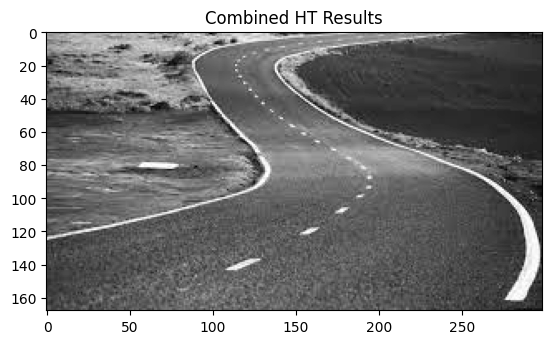

In [10]:

# Example Usage
if __name__ == "__main__":
    input_frame = cv2.imread("/Users/r0p0cbm/Documents/newtest/images.png", cv2.IMREAD_GRAYSCALE)
    
    label_matrix, seeds, neighbour_hood_dict, point_dict = initialize_image_matrix(input_frame, 9, 9)
    
    algorithm_op = Algorithm_X2(input_frame, seeds, point_dict)
    algorithm_op.generate_super_pixels()
    segment_list = algorithm_op.generate_segment_list()
    
    # Apply HT or PHT as needed
    result_image = apply_ht_on_segments_and_combine(input_frame, segment_list)
    
    plt.imshow(result_image, cmap='gray')
    plt.title("Combined HT Results")
    plt.show()


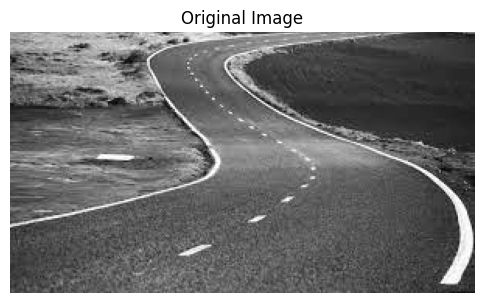

In [11]:
input_frame = cv2.imread("/Users/r0p0cbm/Documents/newtest/images.png", cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(6, 6))
plt.imshow(input_frame, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()


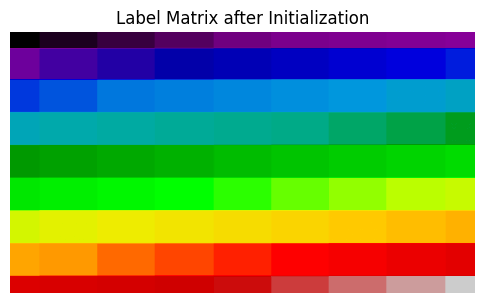

In [12]:

# Initialize the image matrix with seeds and display label matrix for debugging
label_matrix, seeds, neighbour_hood_dict, point_dict = initialize_image_matrix(input_frame, 9, 9)
plt.figure(figsize=(6, 6))
plt.imshow(label_matrix, cmap='nipy_spectral')
plt.title("Label Matrix after Initialization")
plt.axis('off')
plt.show()


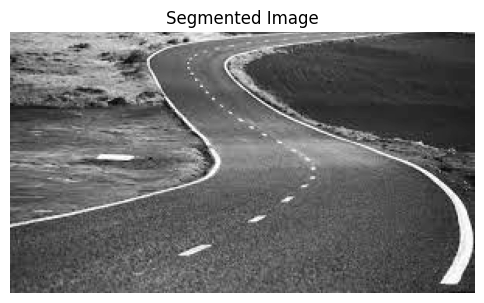

In [13]:

# Run the segmentation algorithm and display the segmented image
algorithm_op = Algorithm_X2(input_frame, seeds, point_dict)
algorithm_op.generate_super_pixels()
segmented_image = algorithm_op.return_image()
plt.figure(figsize=(6, 6))
plt.imshow(segmented_image, cmap='gray')
plt.title("Segmented Image")
plt.axis('off')
plt.show()


Processing segment 1/81


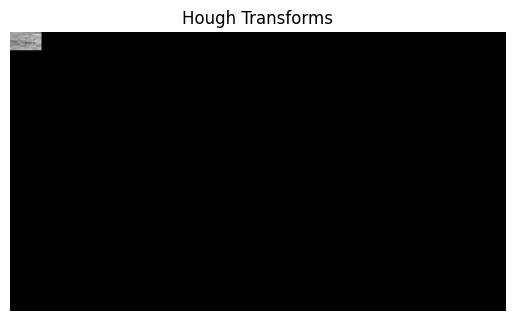

Processing segment 2/81


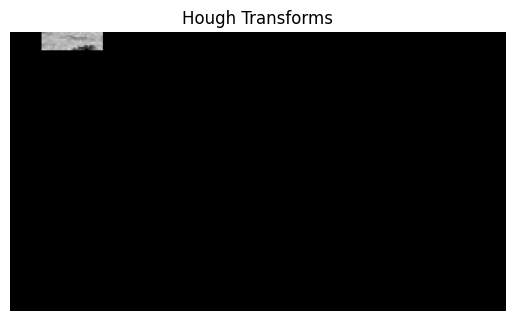

Processing segment 3/81


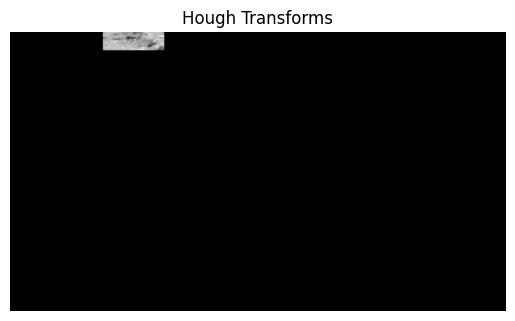

Processing segment 4/81


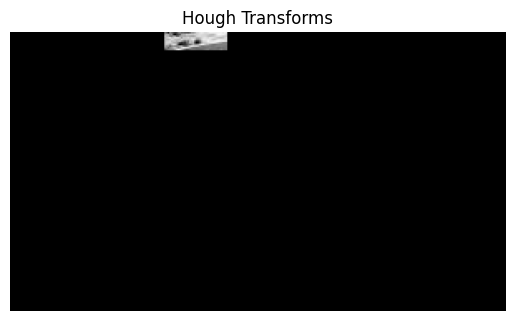

Processing segment 5/81


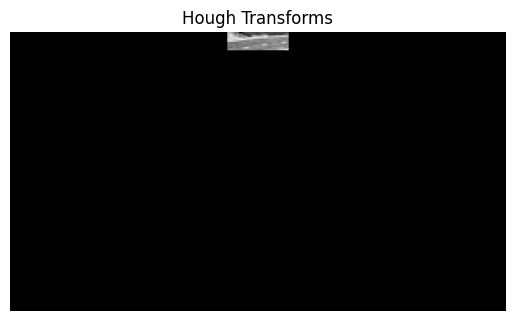

Processing segment 6/81


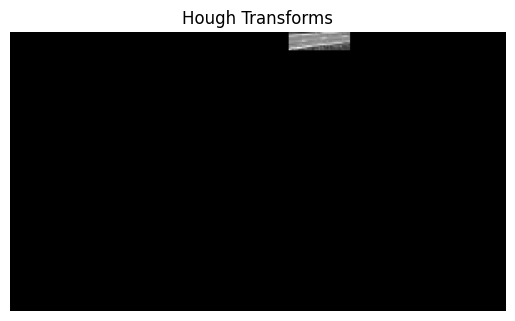

Processing segment 7/81


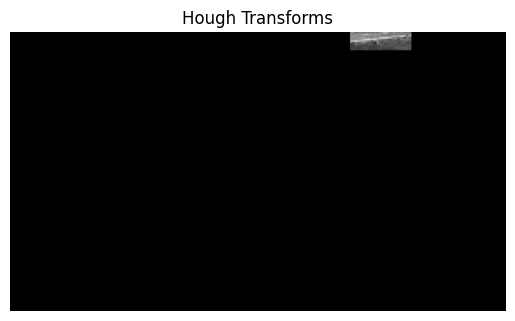

Processing segment 8/81


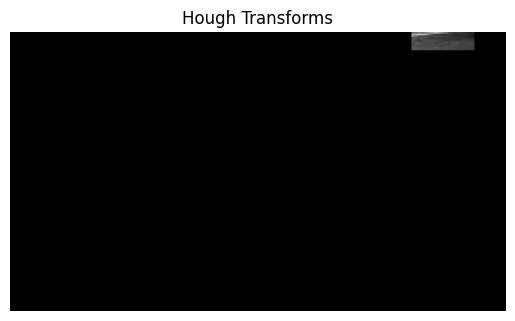

Processing segment 9/81


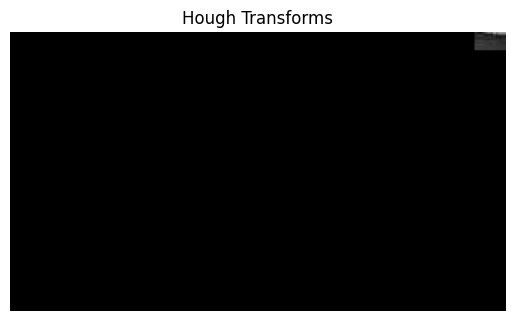

Processing segment 10/81


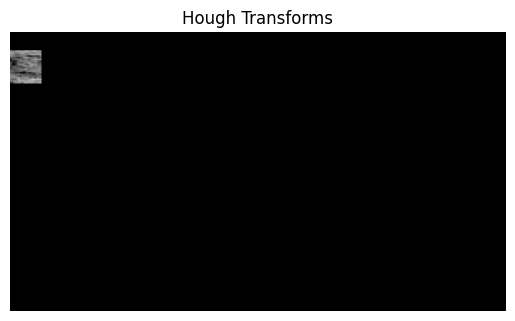

Processing segment 11/81


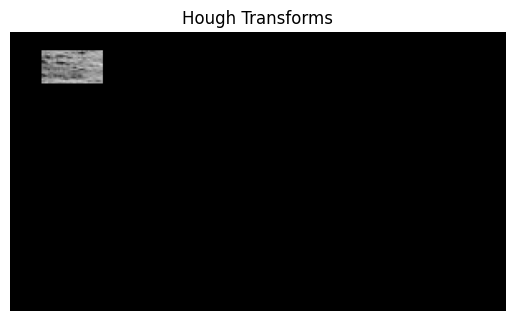

Processing segment 12/81


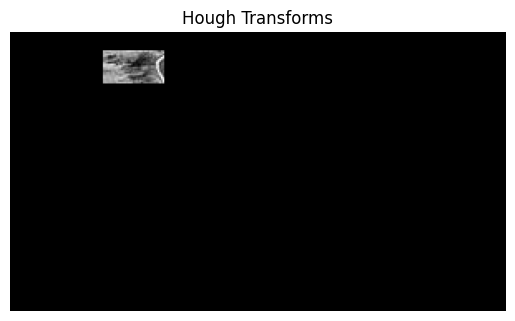

Processing segment 13/81


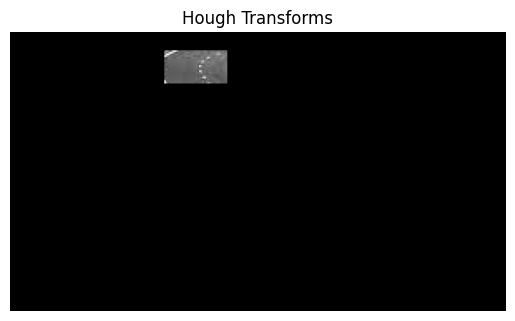

Processing segment 14/81


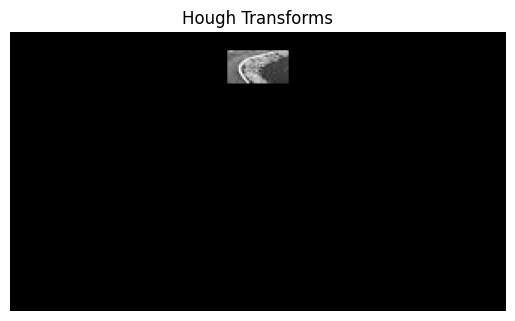

Processing segment 15/81


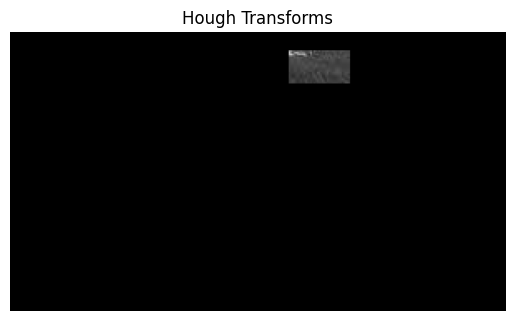

Processing segment 16/81


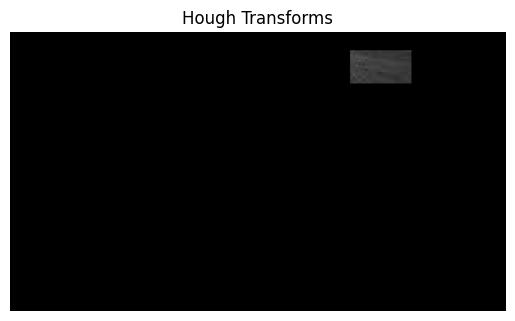

Processing segment 17/81


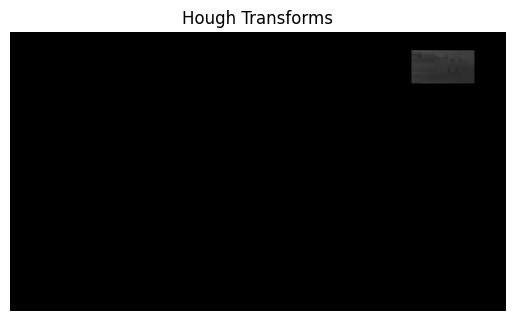

Processing segment 18/81


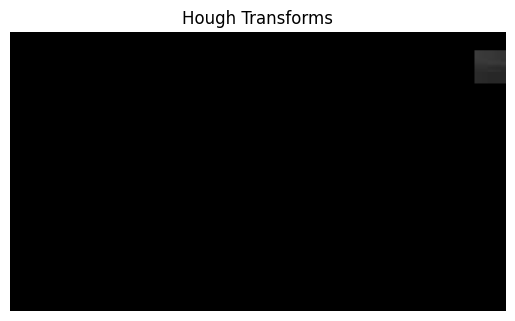

Processing segment 19/81


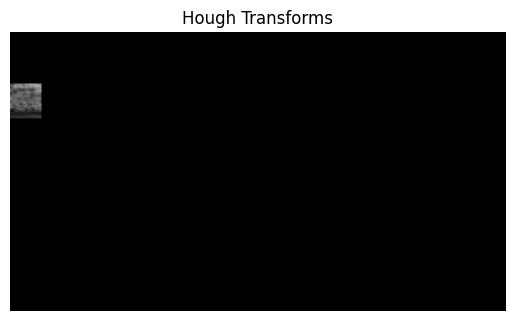

Processing segment 20/81


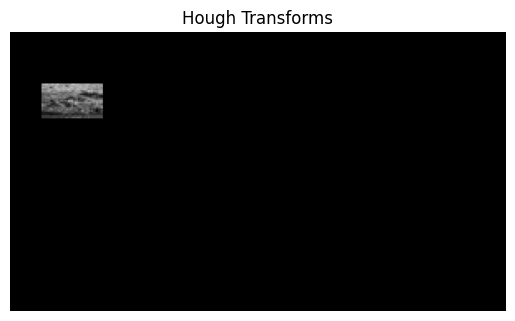

Processing segment 21/81


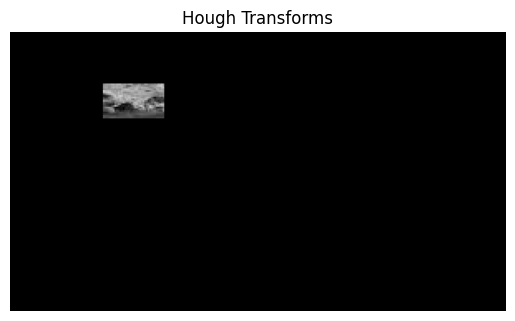

Processing segment 22/81


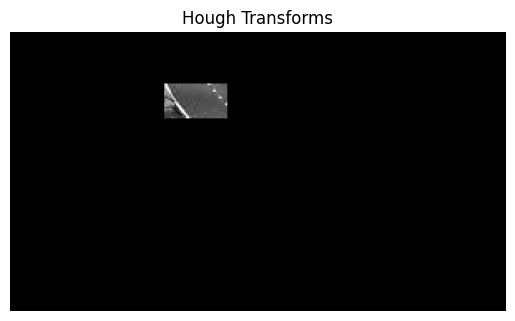

Processing segment 23/81


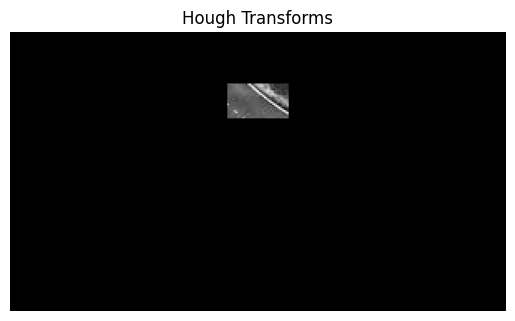

Processing segment 24/81


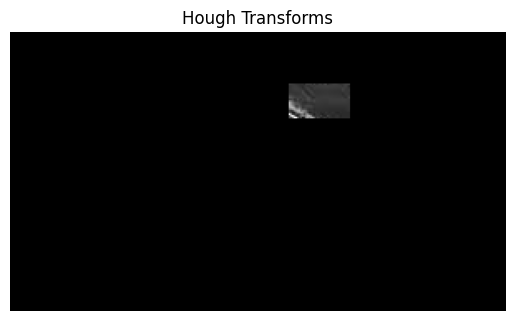

Processing segment 25/81


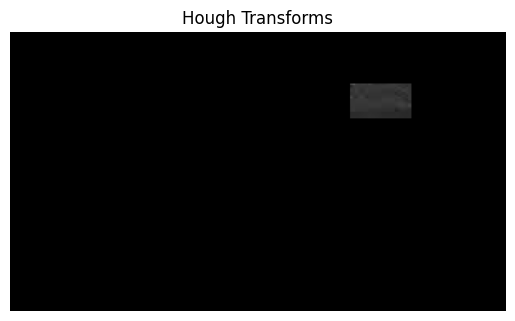

Processing segment 26/81


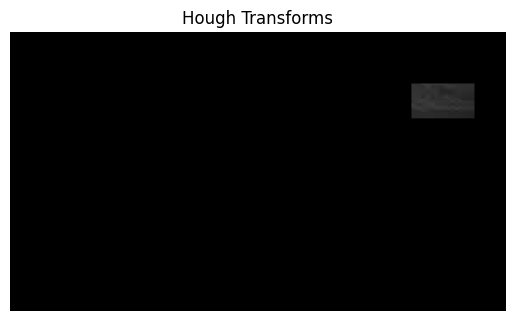

Processing segment 27/81


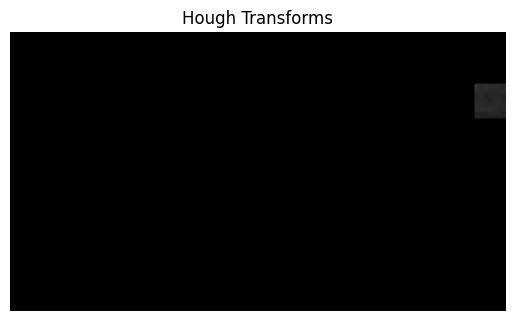

Processing segment 28/81


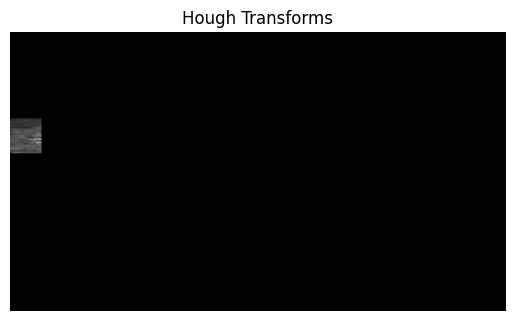

Processing segment 29/81


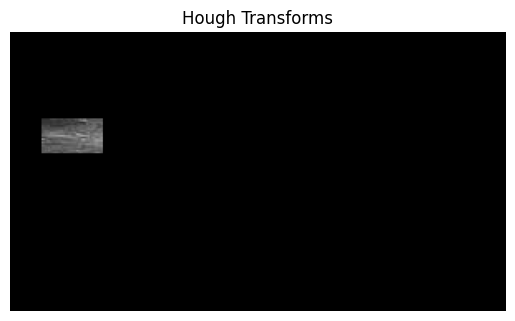

Processing segment 30/81


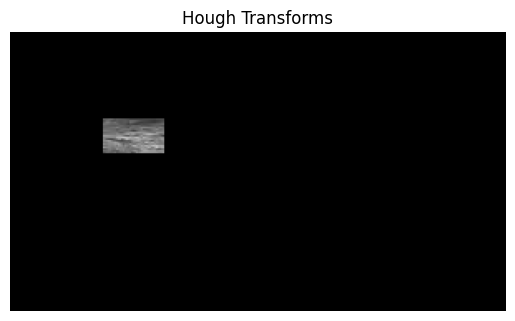

Processing segment 31/81


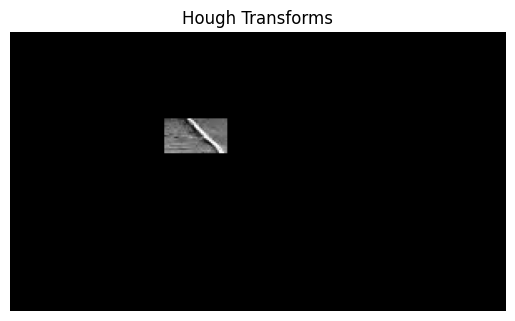

Processing segment 32/81


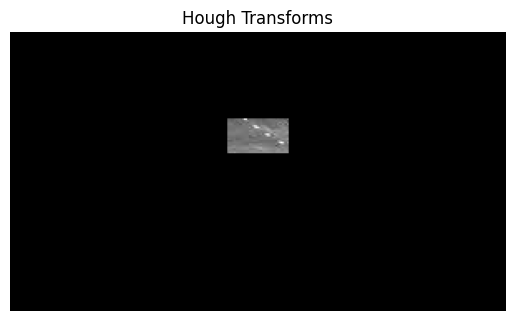

Processing segment 33/81


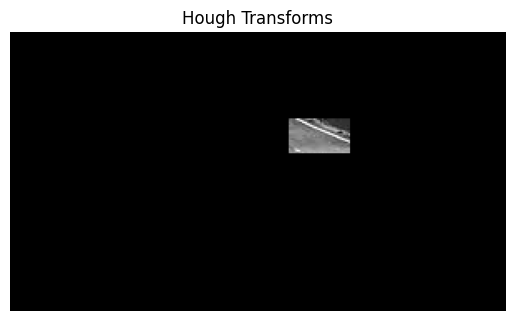

Processing segment 34/81


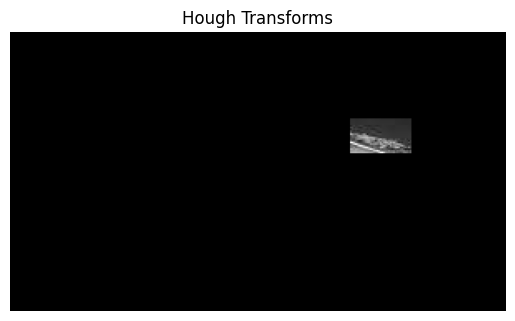

Processing segment 35/81


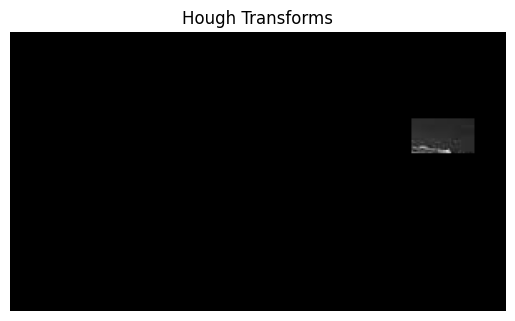

Processing segment 36/81


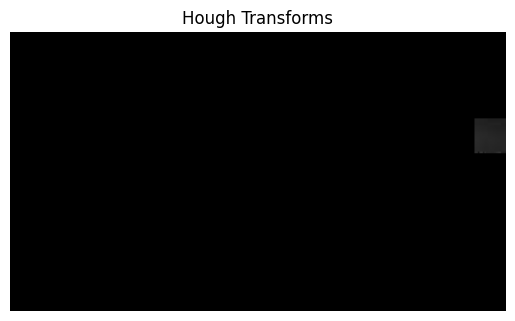

Processing segment 37/81


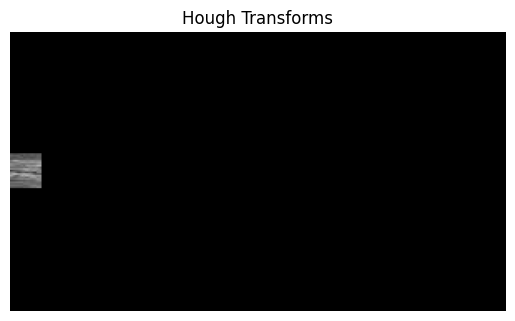

Processing segment 38/81


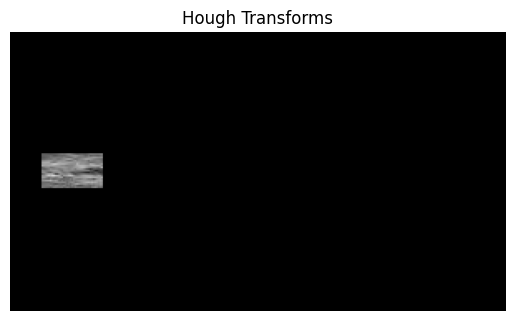

Processing segment 39/81


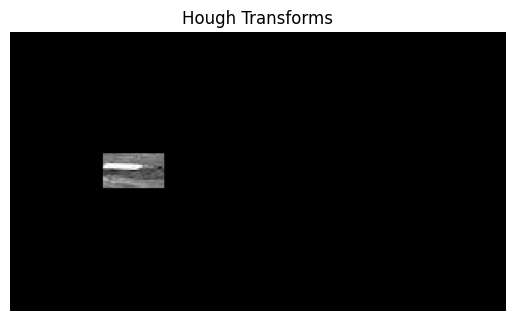

Processing segment 40/81


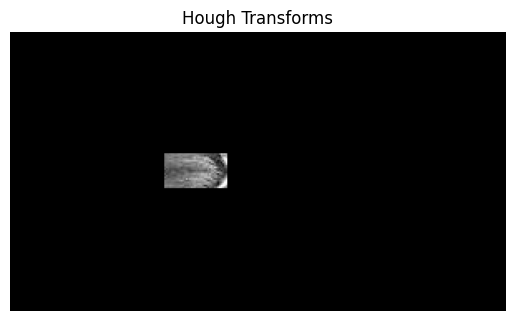

Processing segment 41/81


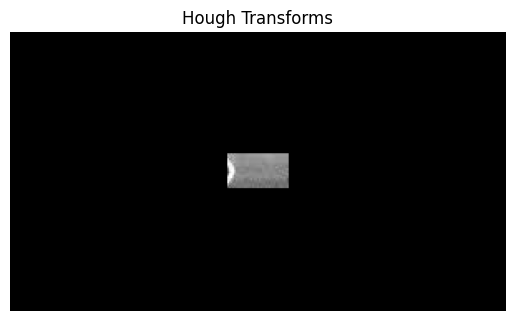

Processing segment 42/81


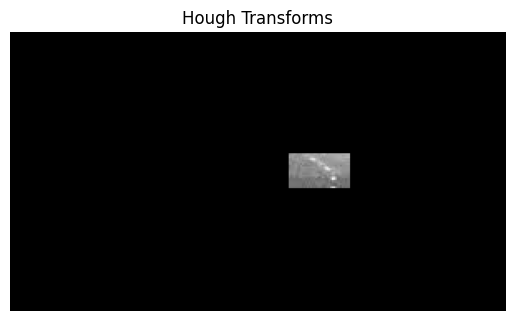

Processing segment 43/81


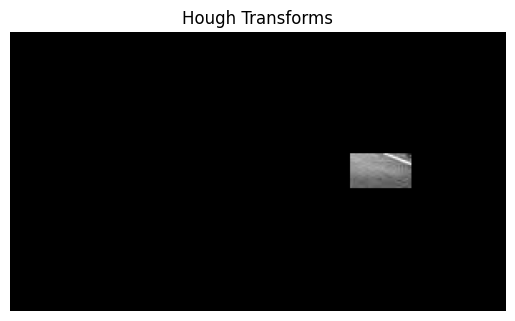

Processing segment 44/81


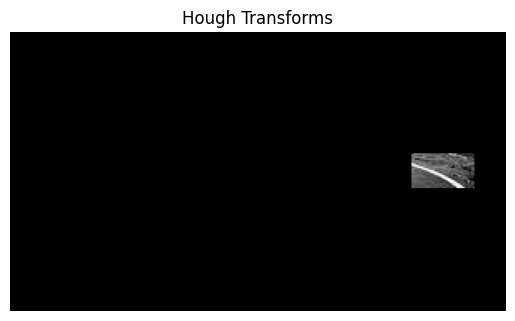

Processing segment 45/81


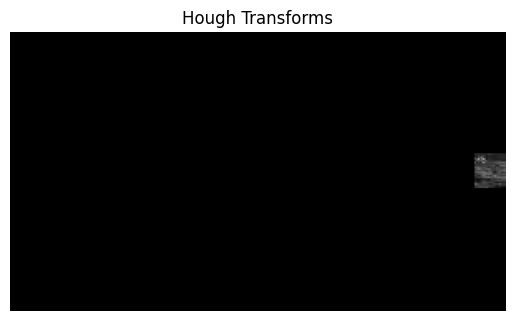

Processing segment 46/81


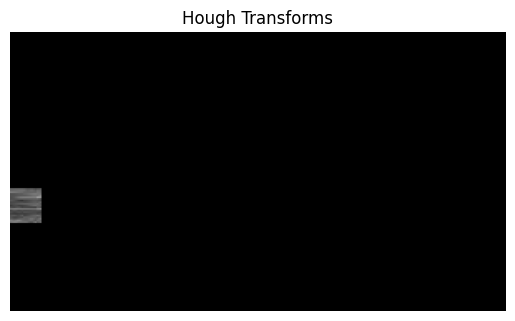

Processing segment 47/81


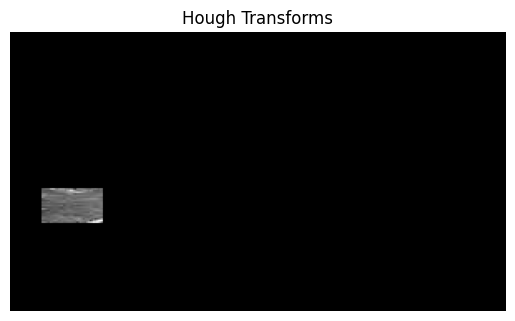

Processing segment 48/81


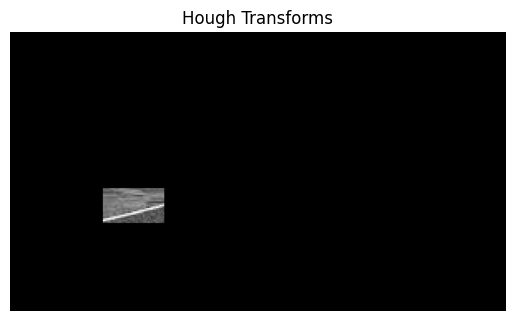

Processing segment 49/81


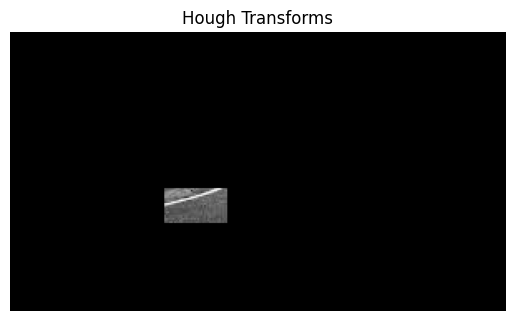

Processing segment 50/81


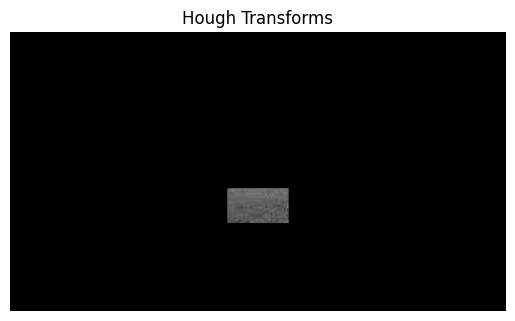

Processing segment 51/81


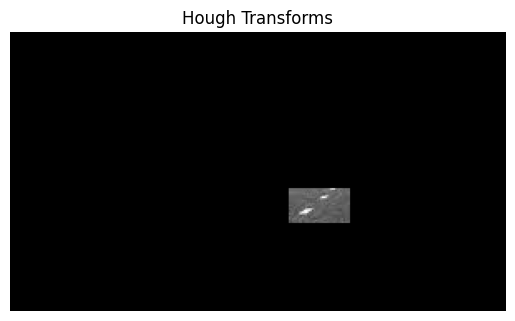

Processing segment 52/81


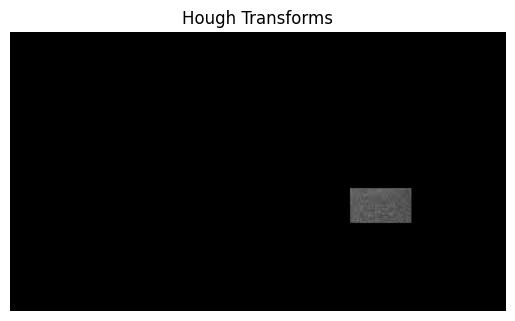

Processing segment 53/81


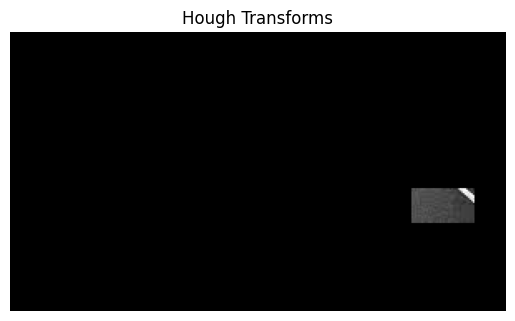

Processing segment 54/81


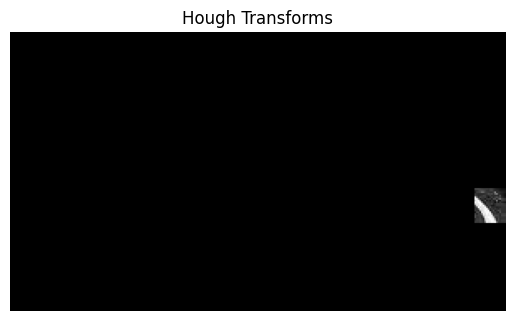

Processing segment 55/81


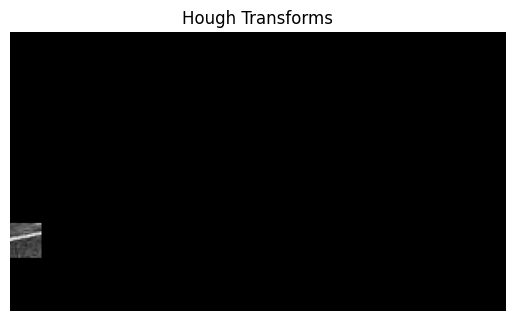

Processing segment 56/81


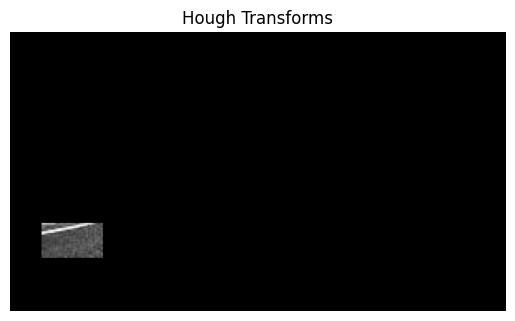

Processing segment 57/81


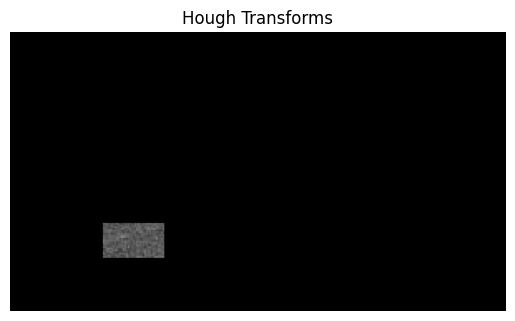

Processing segment 58/81


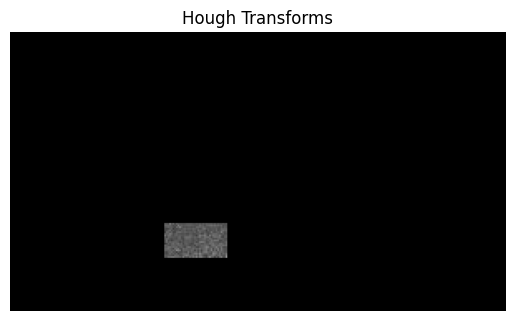

Processing segment 59/81


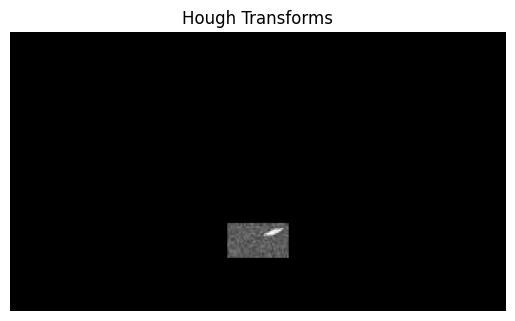

Processing segment 60/81


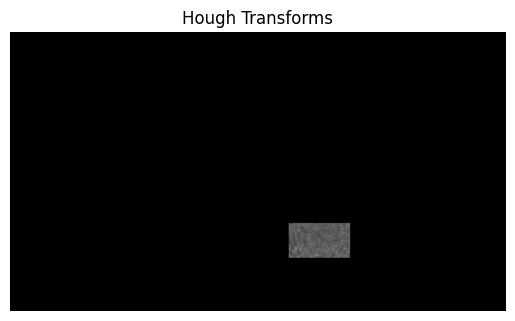

Processing segment 61/81


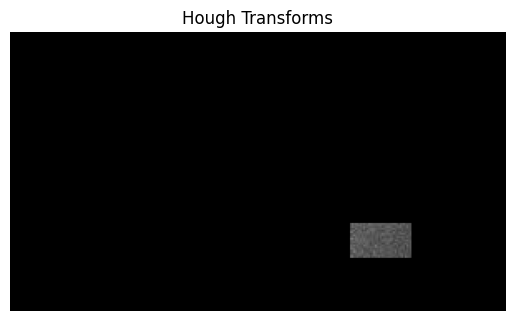

Processing segment 62/81


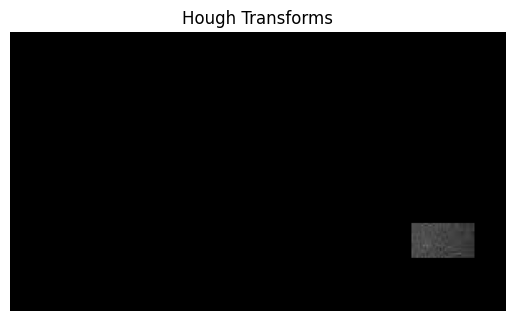

Processing segment 63/81


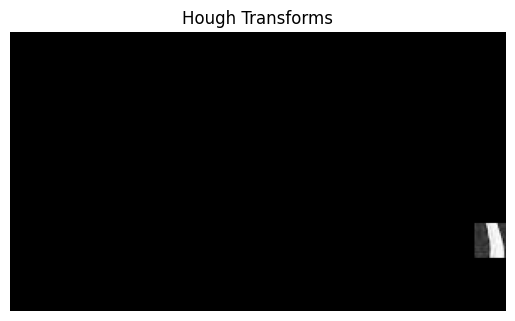

Processing segment 64/81


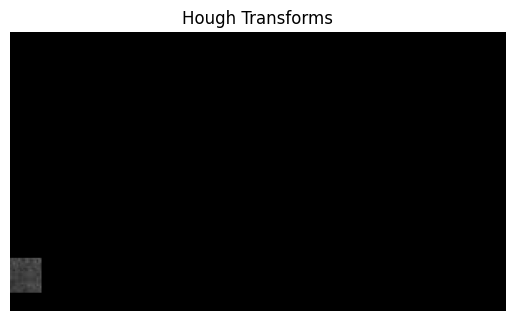

Processing segment 65/81


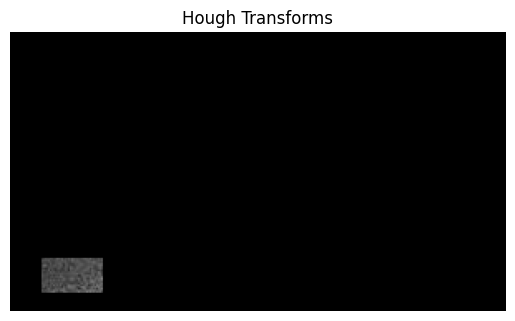

Processing segment 66/81


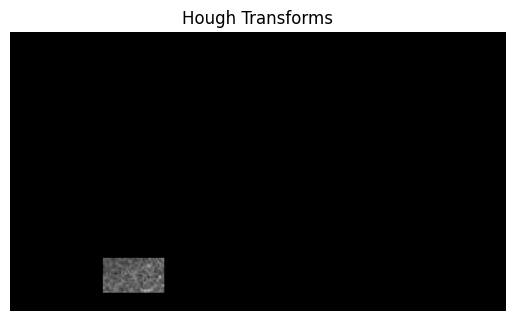

Processing segment 67/81


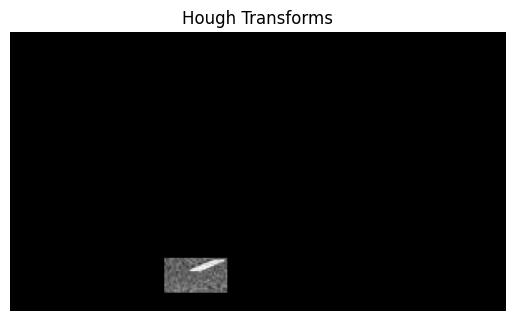

Processing segment 68/81


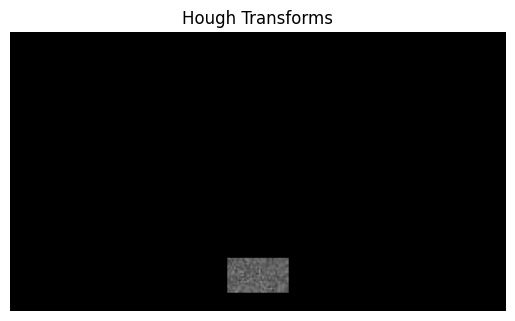

Processing segment 69/81


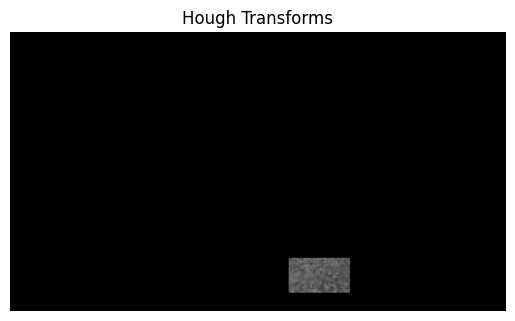

Processing segment 70/81


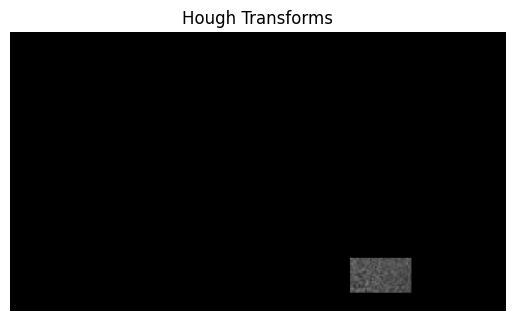

Processing segment 71/81


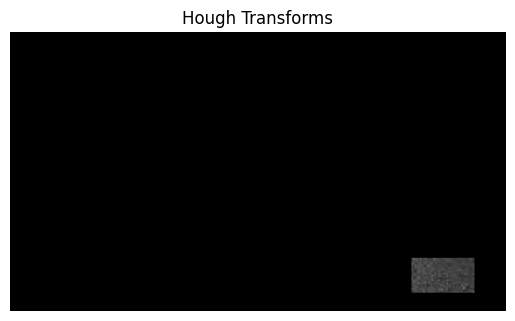

Processing segment 72/81


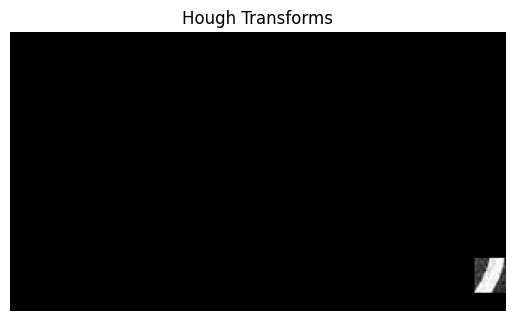

Processing segment 73/81


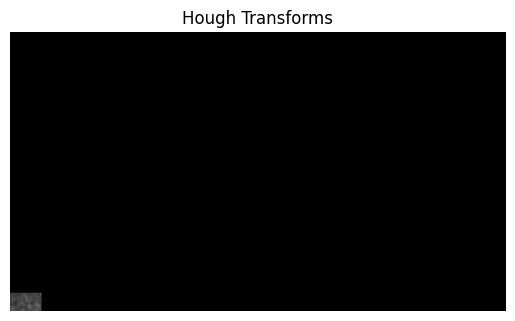

Processing segment 74/81


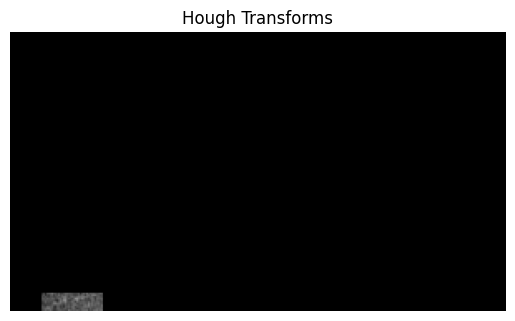

Processing segment 75/81


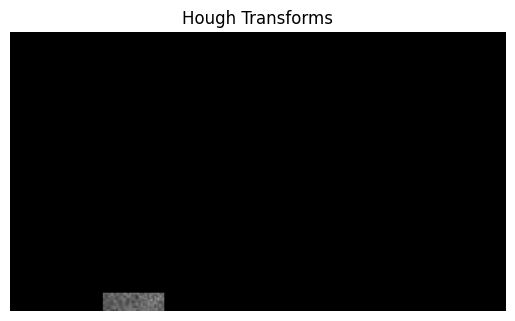

Processing segment 76/81


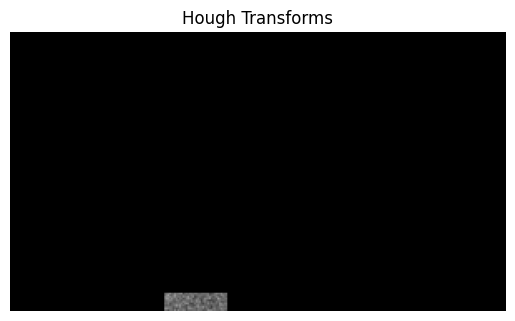

Processing segment 77/81


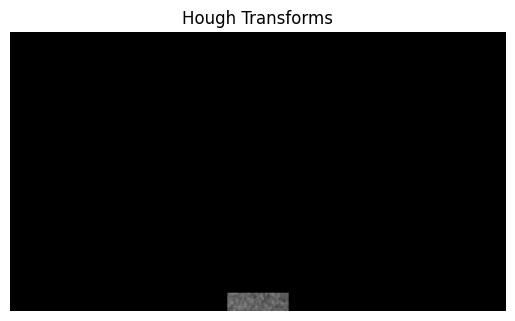

Processing segment 78/81


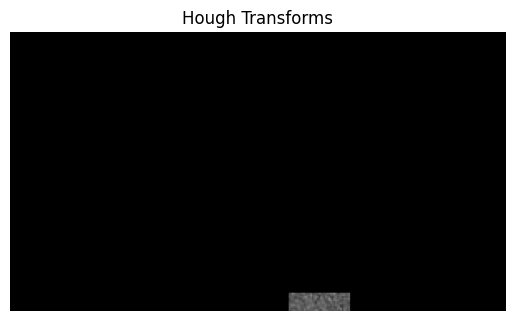

Processing segment 79/81


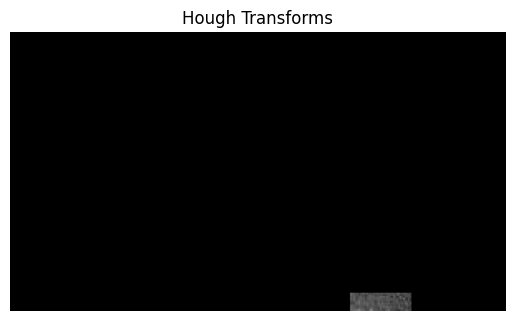

Processing segment 80/81


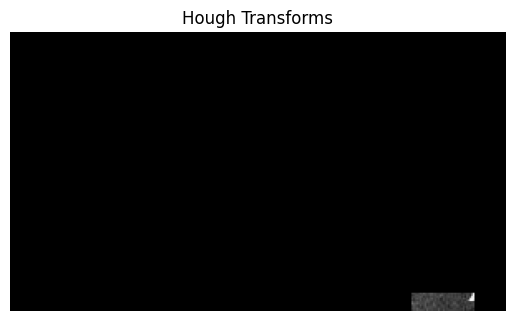

Processing segment 81/81


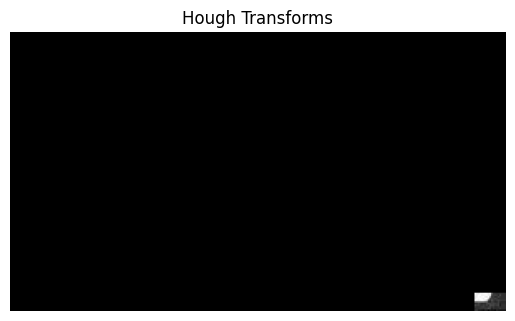

In [16]:
for i, segment_mask in enumerate(segment_list):
    # Prepare the segment image for processing
    segment_region = np.where(segment_mask, input_frame, 0).astype(np.uint8)
    
    # Apply Hough Transform and visualize the results for each segment
    print(f"Processing segment {i+1}/{len(segment_list)}")
    apply_hough_transforms(segment_region)


In [ ]:

# Apply HT or PHT on all segments and combine the results, then display the combined image
result_image = apply_ht_on_segments_and_combine(input_frame, segment_list)
plt.figure(figsize=(6, 6))
plt.imshow(result_image, cmap='gray')
plt.title("Combined HT Results on All Segments")
plt.axis('off')
plt.show()

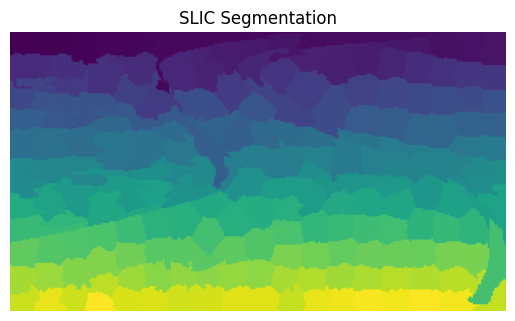

In [18]:
from skimage.segmentation import slic
from skimage.color import gray2rgb
from skimage.util import img_as_float

# Assuming the input_frame is grayscale
input_frame_color = gray2rgb(img_as_float(input_frame))  # SNIC/SLIC requires a 3-channel image

# Apply SLIC for superpixel segmentation
segments_slic = slic(input_frame_color, n_segments=200, compactness=10, sigma=1)

# Visualize the segments
plt.imshow(segments_slic)
plt.title("SLIC Segmentation")
plt.axis('off')
plt.show()


In [8]:

# Load and preprocess the input image (IPM image)
input_frame = cv2.imread("/Users/r0p0cbm/Documents/newtest/images.png")
input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale if necessary

# Step 1: Initialize the image matrix with seeds
label_matrix, seeds_matrix, seeds, neighbour_hood_dict, point_dict = initialize_image_matrix(input_frame, 9, 9)

# Step 2: Run the segmentation algorithm (Algorithm_X2)
algorithm_op = Algorithm_X2(input_frame, seeds, point_dict)
algorithm_op.generate_super_pixels()  # Segmentation process

# Step 3: Generate the list of segments (super-pixels)
segment_arrays = algorithm_op.generate_segment_list()

# Step 4: Apply Hough Transforms on the original image for comparison
print("Applying Hough Transforms on the original image...")
apply_hough_transforms(input_frame.copy())

# Step 5: Apply Hough Transforms on each segment
print("Applying Hough Transforms on each segment...")
apply_ht_on_segments_and_combine(input_frame, segment_arrays)

# Step 6: (Optional) Display or process the segmented image
segmented_image = algorithm_op.return_image()
plt.imshow(segmented_image, cmap='gray')
plt.title("Segmented Image")
plt.show()


100%|██████████| 168/168 [00:13<00:00, 12.22it/s]


ValueError: cannot reshape array of size 162 into shape (9,9)